In [ ]:
# Debug Cell: print out columns for each season’s raw CSV
paths = {
    '2022': '2022_reg_season_odds.csv',
    '2023': '2023_reg_season_odds.csv',
    '2024': '2024_reg_season_odds.csv'
}

for season, fp in paths.items():
    tmp = pd.read_csv(fp)
    print(f"{season} shape: {tmp.shape}")
    print(f"{season} columns ({len(tmp.columns)}): {tmp.columns.tolist()}\n")

2022 shape: (271, 11)
2022 columns (11): ['Day', 'Date', 'Time (ET)', ' ', 'Favorite', 'Score', 'Spread', ' .1', 'Underdog', 'Over/Under', 'Notes']

2023 shape: (288, 11)
2023 columns (11): ['Day', 'Date', 'Time (ET)', ' ', 'Favorite', 'Score', 'Spread', ' .1', 'Underdog', 'Over/Under', 'Notes']

2024 shape: (272, 11)
2024 columns (11): ['Day', 'Date', 'Time (ET)', ' ', 'Favorite', 'Score', 'Spread', ' .1', 'Underdog', 'Over/Under', 'Notes']



In [ ]:
# Cell 1: Load & Initial Cleaning for 2022–2024 (fixed column names)
import pandas as pd
import re

paths = {
    '2022': '2022_reg_season_odds.csv',
    '2023': '2023_reg_season_odds.csv',
    '2024': '2024_reg_season_odds.csv'
}
dfs = []
for season, fp in paths.items():
    df = pd.read_csv(fp)
    df['Season'] = season

    # Drop the junk columns: the blank " " column and the ".1" column, plus Notes
    df = df.drop(columns=[' ', ' .1', 'Notes'])

    # Rename to your standard names
    df = df.rename(columns={
        'Time (ET)': 'Time_ET',
        'Over/Under': 'Over_Under'
    })

    # Now df.columns should be:
    # ['Day','Date','Time_ET','Favorite','Score','Spread','Underdog','Over_Under','Season']
    # Reorder and insert a placeholder Location (all blanks for now)
    df['Location'] = ''
    df = df[[
        'Season','Day','Date','Time_ET','Location',
        'Favorite','Underdog','Score','Spread','Over_Under'
    ]]

    # Finally rename Favorite/Underdog -> Team_A/Team_B
    df = df.rename(columns={
        'Favorite': 'Team_A',
        'Underdog': 'Team_B'
    })

    dfs.append(df)

cleaned_df = pd.concat(dfs, ignore_index=True)
print("Combined rows:", len(cleaned_df))
print(cleaned_df['Season'].value_counts(), "\n")
cleaned_df.head()

Combined rows: 831
Season
2023    288
2024    272
2022    271
Name: count, dtype: int64 



,Season,Day,Date,Time_ET,Location,Team_A,Team_B,Score,Spread,Over_Under
0,2022,Thu,"Sep 8, 2022",8:20,,Buffalo Bills,Los Angeles Rams,W 31-10,W -2.5,U 52
1,2022,Sun,"Sep 11, 2022",1:00,,New Orleans Saints,Atlanta Falcons,W 27-26,L -5.5,O 43.5
2,2022,Sun,"Sep 11, 2022",1:00,,Carolina Panthers,Cleveland Browns,L 24-26,L -1.5,O 42
3,2022,Sun,"Sep 11, 2022",1:00,,San Francisco 49ers,Chicago Bears,L 10-19,L -6,U 38
4,2022,Sun,"Sep 11, 2022",1:00,,Cincinnati Bengals,Pittsburgh Steelers,L 20-23 (OT),L -7,U 44


In [ ]:
# Cell 2: Extract Numeric Features (identical to your Cell 2, applied to all seasons)
def extract_scores(s):
    m = re.search(r'(\d+)-(\d+)', str(s))
    return (int(m[1]), int(m[2])) if m else (None, None)

# 1. Scores
cleaned_df[['Team_A_Score','Team_B_Score']] = (
    cleaned_df['Score']
      .apply(lambda x: pd.Series(extract_scores(x)))
)

# 2. Flags
cleaned_df['Team_A_Win']     = cleaned_df['Score'].str.startswith('W').astype(int)
cleaned_df['Team_A_Covered'] = cleaned_df['Spread'].str.startswith('W').astype(int)
cleaned_df['OU_Line']        = cleaned_df['Over_Under'].str.extract(r'(\d+\.?\d*)').astype(float)
cleaned_df['Over_Hit']       = cleaned_df['Over_Under'].str.startswith('O').astype(int)

# 3. Spread numeric + diffs
cleaned_df['Spread_Value'] = cleaned_df['Spread'] \
    .str.extract(r'([-+]?\d+\.?\d*)') \
    .astype(float)
cleaned_df['Point_Diff']   = cleaned_df['Team_A_Score'] - cleaned_df['Team_B_Score']
cleaned_df['Spread_Diff']  = cleaned_df['Point_Diff'] - cleaned_df['Spread_Value'].abs()

# 4. Drop raw text
cleaned_df = cleaned_df.drop(columns=['Score','Spread','Over_Under'])
cleaned_df.head()

,Season,Day,Date,Time_ET,Location,Team_A,Team_B,Team_A_Score,Team_B_Score,Team_A_Win,Team_A_Covered,OU_Line,Over_Hit,Spread_Value,Point_Diff,Spread_Diff
0,2022,Thu,"Sep 8, 2022",8:20,,Buffalo Bills,Los Angeles Rams,31,10,1,1,52.0,0,-2.5,21,18.5
1,2022,Sun,"Sep 11, 2022",1:00,,New Orleans Saints,Atlanta Falcons,27,26,1,0,43.5,1,-5.5,1,-4.5
2,2022,Sun,"Sep 11, 2022",1:00,,Carolina Panthers,Cleveland Browns,24,26,0,0,42.0,1,-1.5,-2,-3.5
3,2022,Sun,"Sep 11, 2022",1:00,,San Francisco 49ers,Chicago Bears,10,19,0,0,38.0,0,-6.0,-9,-15.0
4,2022,Sun,"Sep 11, 2022",1:00,,Cincinnati Bengals,Pittsburgh Steelers,20,23,0,0,44.0,0,-7.0,-3,-10.0


In [ ]:
# Cell 3: Team‐Level Summaries by Season
# (optional — you can also skip this and go straight to your original Cells 5–8 on a filtered df)

summaries = []
for season, df_s in cleaned_df.groupby('Season'):
    # Underdog flags
    df_s = df_s.copy()
    df_s['Team_B_Win']     = 1 - df_s['Team_A_Win']
    df_s['Team_B_Covered'] = 1 - df_s['Team_A_Covered']

    # Long format
    fav = df_s[['Team_A','Team_A_Win','Team_A_Covered','Over_Hit']].rename(
        columns={'Team_A':'Team','Team_A_Win':'Win','Team_A_Covered':'Covered'}
    )
    dog = df_s[['Team_B','Team_B_Win','Team_B_Covered','Over_Hit']].rename(
        columns={'Team_B':'Team','Team_B_Win':'Win','Team_B_Covered':'Covered'}
    )
    long = pd.concat([fav,dog], ignore_index=True)

    # Aggregate
    summ = (
        long
        .groupby('Team')
        .agg(
            Win_Pct=('Win','mean'),
            Cover_Pct=('Covered','mean'),
            Over_Pct=('Over_Hit','mean'),
            Games_Played=('Team','count')
        )
        .round(3)
        .reset_index()
    )
    summ['Season'] = season
    summaries.append(summ)

team_summary_df = pd.concat(summaries).sort_values(['Season','Games_Played'], ascending=False)
team_summary_df.head(10)

,Team,Win_Pct,Cover_Pct,Over_Pct,Games_Played,Season
0,Arizona Cardinals,0.471,0.647,0.471,17,2024
1,Atlanta Falcons,0.471,0.353,0.412,17,2024
2,Baltimore Ravens,0.706,0.588,0.765,17,2024
3,Buffalo Bills,0.765,0.588,0.647,17,2024
4,Carolina Panthers,0.294,0.471,0.765,17,2024
5,Chicago Bears,0.294,0.588,0.412,17,2024
6,Cincinnati Bengals,0.529,0.588,0.647,17,2024
7,Cleveland Browns,0.176,0.235,0.412,17,2024
8,Dallas Cowboys,0.412,0.412,0.647,17,2024
9,Denver Broncos,0.588,0.706,0.588,17,2024


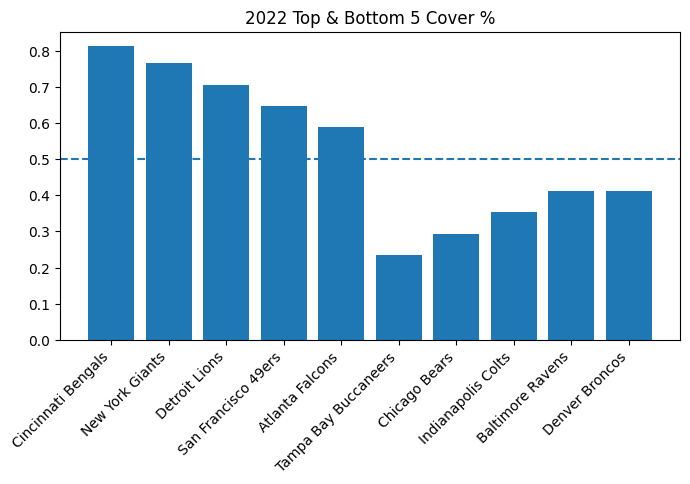

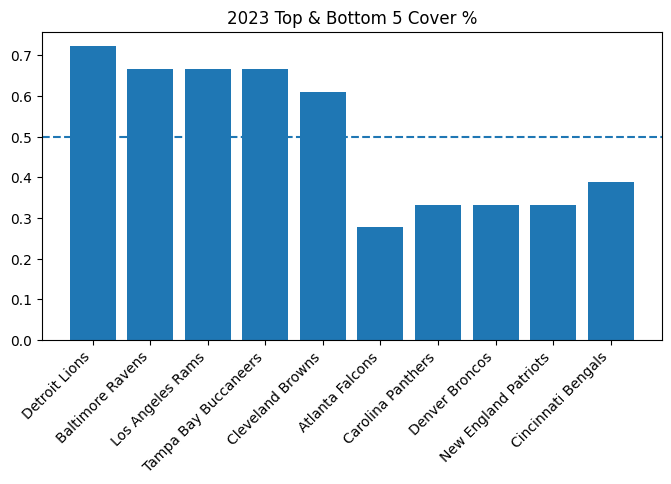

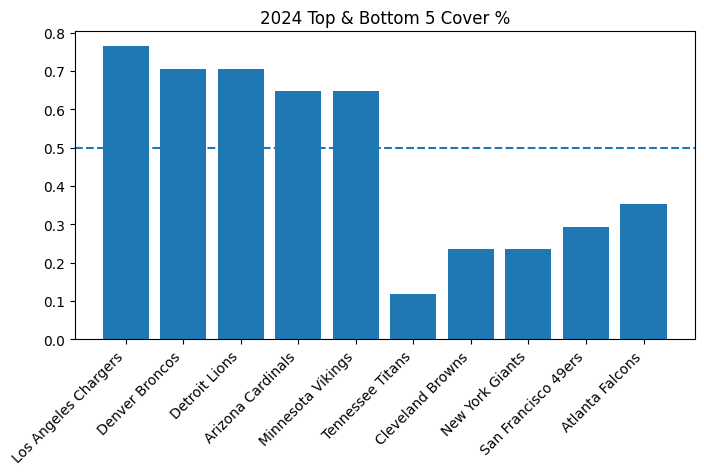

In [ ]:
# Cell 4: (Re-use your existing Visualizations, but loop by season)
import matplotlib.pyplot as plt

for season in ['2022','2023','2024']:
    df_summ = team_summary_df.query("Season == @season")
    # Top/bottom cover
    top5 = df_summ.nlargest(5,'Cover_Pct')
    bot5 = df_summ.nsmallest(5,'Cover_Pct')
    plt.figure(figsize=(8,4))
    plt.bar(pd.concat([top5,bot5])['Team'], pd.concat([top5,bot5])['Cover_Pct'])
    plt.axhline(0.5, linestyle='--')
    plt.title(f'{season} Top & Bottom 5 Cover %')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
# Cell 5: Split into train (2022–23) and test (2024)
train_df = cleaned_df[cleaned_df['Season'].isin(['2022','2023'])].reset_index(drop=True)
test_df  = cleaned_df[cleaned_df['Season']=='2024'].reset_index(drop=True)
print(f"Training games: {len(train_df)}, Test games: {len(test_df)}")

Training games: 559, Test games: 272


In [ ]:
# Cell 6: Train logistic on signed spread and predict implied P on test set
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
X_train = train_df[['Spread_Value']].values.reshape(-1,1)
y_train = train_df['Team_A_Covered']
lr.fit(X_train, y_train)

X_test = test_df[['Spread_Value']].values.reshape(-1,1)
test_df['Implied_P'] = lr.predict_proba(X_test)[:, 1]

In [ ]:
# Cell 7: Compute empirical cover, implied avg, and Edge per team on test set
empirical = test_df.groupby('Team_A')['Team_A_Covered'] \
                  .mean().rename('Empirical_P')
implied_avg = test_df.groupby('Team_A')['Implied_P'] \
                    .mean().rename('Implied_Avg_P')

edges = pd.concat([empirical, implied_avg], axis=1).reset_index()
edges['Edge'] = edges['Empirical_P'] - edges['Implied_Avg_P']

test_df = test_df.merge(edges[['Team_A','Edge']], on='Team_A', how='left')

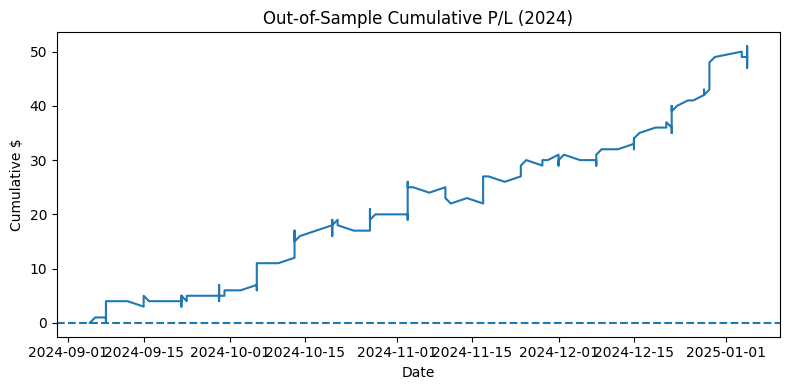

2024 value bets: 159
Win rate on bets: 65.4%
Total P/L: $49.00


In [ ]:
# Cell 8: Flag value bets, simulate flat-$1 P/L, plot cumulative P/L, and summary
threshold = 0.05
test_df['Value_Bet'] = (test_df['Edge'] > threshold).astype(int)
test_df['PnL']       = test_df['Value_Bet'] * (2*test_df['Team_A_Covered'] - 1)

# Cumulative P/L over 2024
test_df['Game_Date'] = pd.to_datetime(test_df['Date'])
cum = test_df.sort_values('Game_Date') \
             .assign(Cum_PnL=lambda d: d['PnL'].cumsum())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(cum['Game_Date'], cum['Cum_PnL'])
plt.axhline(0, linestyle='--')
plt.title('Out-of-Sample Cumulative P/L (2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative $')
plt.tight_layout()
plt.show()

# Summary stats
total_bets = test_df['Value_Bet'].sum()
win_rate   = test_df.loc[test_df['Value_Bet']==1, 'Team_A_Covered'].mean()
total_pnl  = test_df['PnL'].sum()

print(f"2024 value bets: {total_bets}")
print(f"Win rate on bets: {win_rate:.1%}")
print(f"Total P/L: ${total_pnl:.2f}")

In [ ]:
# Cell 9: Threshold sweep
import numpy as np
import pandas as pd

results = []
for thr in np.arange(0, 0.21, 0.01):
    df = test_df.copy()
    df['Value_Bet'] = (df['Edge'] > thr).astype(int)
    df['PnL']       = df['Value_Bet'] * (2*df['Team_A_Covered'] - 1)
    total_bets = df['Value_Bet'].sum()
    total_pnl  = df['PnL'].sum()
    win_rate   = df.loc[df['Value_Bet']==1, 'Team_A_Covered'].mean() if total_bets>0 else np.nan
    results.append({'threshold': thr, 'bets': total_bets, 'pnl': total_pnl, 'win_rate': win_rate})

sweep_df = pd.DataFrame(results)
sweep_df

,threshold,bets,pnl,win_rate
0,0.00,167,49,0.646707
1,0.01,159,49,0.654088
2,0.02,159,49,0.654088
3,0.03,159,49,0.654088
4,0.04,159,49,0.654088
5,0.05,159,49,0.654088
6,0.06,159,49,0.654088
7,0.07,148,48,0.662162
8,0.08,139,47,0.669065
9,0.09,118,44,0.686441


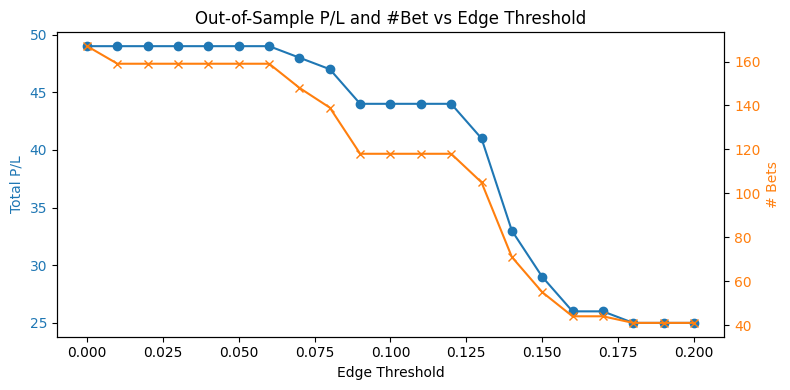

In [ ]:
# Cell 10: Plot P/L and #bets vs threshold
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(sweep_df['threshold'], sweep_df['pnl'], marker='o')
ax1.set_xlabel('Edge Threshold')
ax1.set_ylabel('Total P/L', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(sweep_df['threshold'], sweep_df['bets'], marker='x', color='tab:orange')
ax2.set_ylabel('# Bets', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Out-of-Sample P/L and #Bet vs Edge Threshold')
plt.tight_layout()
plt.show()